## Introduction

#### Author - Chaman Gupta
#### Last Updated - 05/14/2023

Install the following libraries by copying each line to your command prompt/terminal:

***
`pip install traitlets`

`pip install peakutils`

`pip install ipywidgets`

`pip install tkinter`
***

### Import Libraries

In [1]:

# Import libraries
import os
import traitlets
from ipywidgets import *
from IPython.display import display, Javascript, clear_output

import numpy as np
import pandas as pd
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline                    # Safe smooth interpolation
from scipy.signal import find_peaks
from scipy.signal import medfilt
from scipy import signal
from pybaselines import Baseline, utils
from scipy.integrate import simpson, trapz

from tkinter import Tk, filedialog

import peakutils
from peakutils.plot import plot as pplot

from tqdm import tqdm

from helpers import *

### Set graphing properties

In [2]:
## Set graphing properties

matplotlib.rcParams['font.sans-serif'] = ['Arial'] # Helvetica
plt.rcParams["figure.figsize"] = (15,7)

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Clean Intensity Correction files

In [3]:
do_lamp_cleaning = 'n' # y or n

if do_lamp_cleaning == 'y':
    print("\nSelect lamp files for cleaning and analysis \n(optional; if none is chosen, default intensity correction factor will be used): ")
    selectiCorrFiles = SelectFilesButton()
    display(selectiCorrFiles)
else:
    pass


In [4]:
## Variables
do_baseline_subtraction = 'n' # 'y', 'n'
do_median_filtering = 'n' # 'y', 'n'
do_data_cleaning = 'n' # 'y', 'n'
do_savgol_filtering = 'n' # 'y', 'n'
do_conversion = 'n' # 'raman', 'energy', 'n'
do_normalize = 'n' # 'relative' scale', 'area', 'n'
do_peak_finding = 'n' # 'y', 'n'

c_vac = 2.99*10**8 # speed of light in vacuum m/sec
laser_source = 532 # Excitation source in nm

p_order = 5 # Polynomial order for baseline subtraction
k_size = 7 # Kernel size for Median Filtering
erp = -10
k_size_savgol = 11
p_order_savgol = 1

In [5]:
if do_lamp_cleaning == 'y':
    i_corr_cleaning(selectiCorrFiles,do_baseline_subtraction,do_median_filtering,do_data_cleaning,do_savgol_filtering,do_conversion,do_normalize,do_peak_finding,p_order,k_size,erp,k_size_savgol,p_order_savgol)
else:
    pass

## Files for averaging and cosmic ray cleaning

In [6]:
print("Select data files to remove cosmic rays or average: ")
cleanFiles = SelectFilesButton()
display(cleanFiles)

Select data files to remove cosmic rays or average: 


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

### Cosmic Ray Removal and Averaging

In [7]:
do_cosmic_rays_removal = 'n'
if do_cosmic_rays_removal == 'y':
    x_data, cosmic_removed_data = remove_cosmic_rays(cleanFiles,batching=False,batch_size=3,average=False)
    print("cosmic rays removed")
        
    plt.plot(x_data,cosmic_removed_data)
    plt.show()

do_data_averaging = 'y'
if do_data_averaging == 'y':
    x_data, averaged_data = data_averaging(cleanFiles,average=True,batching=True,batch_size=5)
    print("data averaged")
        
    plt.plot(x_data,averaged_data)
    plt.show()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2136 and the array at index 1 has size 29

## Manual Intensity Correction

In [6]:
print("Select data files you want to analyze: ")
selectFiles = SelectFilesButton()
display(selectFiles)

do_intensity_correction = 'n'

if do_intensity_correction == 'y':
    print("\nSelect tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction \n(optional; if none is chosen, default intensity correction factor will be used): ")
    selectHalLamp = SelectFilesButton()
    display(selectHalLamp)
else:
    pass

Select data files you want to analyze: 


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

## Main Data Processing and Plotting

In [7]:
## Variables
is_fitted_data_file = False # 'y', 'n'
do_baseline_subtraction = 'n' # 'y', 'n'
do_median_filtering = 'n' # 'y', 'n'
do_data_cleaning = 'n' # 'y', 'n'
do_savgol_filtering = 'n' # 'y', 'n'
do_conversion = 'n' # 'raman', 'energy', 'n'
do_normalize = 'n' # 'relative' scale', 'area', 'n'
do_peak_finding = 'n' # 'y', 'n'
do_slicing = 'n'
do_mfv_calc = 'n'
do_data_averaging = 'n'

meanf_method = 'energy'

hf = 20
p_order = 5 # Polynomial order for baseline subtraction
k_size = 7 # Kernel size for Median Filtering
erp = -5
k_size_savgol = 3
p_order_savgol = 1

start_x = 830
end_x = 1020

base = 0

c_vac = 2.99*10**8 # speed of light in vacuum m/sec
laser_source = 532.109 # Excitation source in nm 

  0%|          | 0/134 [00:00<?, ?it/s]


KeyError: 1

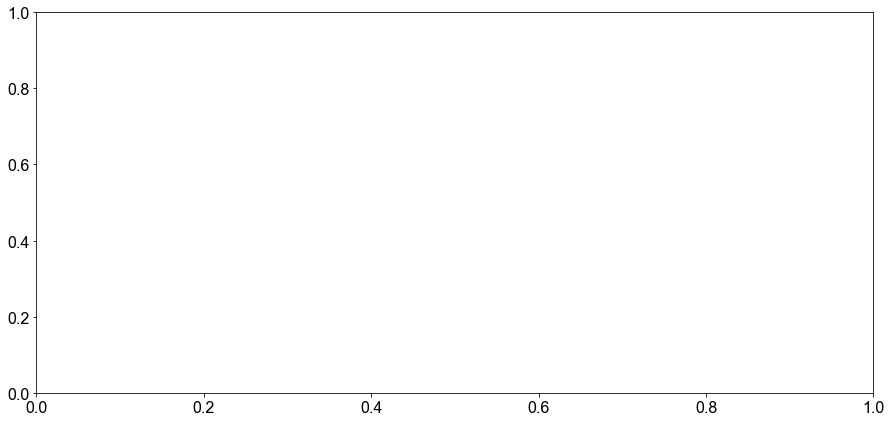

In [8]:
fdata = selectFiles.files

if do_intensity_correction == 'y':
    flamp = selectHalLamp.files
else:
    pass

x_label = 'Wavelength (nm)' # Set a default label for x-axis to Wavelength.

laser_Pow = []

meanf_df = pd.DataFrame(columns=('File Name','Power', 'Mean Wvl'))

lab = ['on-sample', 'off-sample']
color_lab = ['k','b']
power_lab = []

# Put this outside loop if you want only one plot with all cruves. Keep it inside if you want separate plots

fig1 = plt.figure()

if do_mfv_calc == 'y':
    ax1 = fig1.add_subplot(121)
    ax2 = fig1.add_subplot(122)
else:
    ax1 = fig1.add_subplot(111)

for i in tqdm(range(0, len(fdata))):
    
    # fig1 = plt.figure()
    # ax1 = fig1.add_subplot(121) # Put this outside loop if you want only one plot with all cruves. Keep it inside if you want separate plots

    head_i, tail_i = os.path.split(fdata[i])
    
    x_data, y_data, metadata = DataReader(file_name=fdata[i]).read_file()
    # print(metadata)
    if do_intensity_correction == 'y': x_data, y_data, intens_data = i_corr(flamp, fdata, i)
    else: intens_data = y_data

    if do_slicing == 'y': x_data, y_data, intens_data, start, end = slicing_func(x_data,y_data,intens_data,start_x,end_x)

    norm_intens_data = norm_func(x_data,y_data,do_normalize)
    
    
    if do_median_filtering == 'y': filt_data = filter_median(norm_intens_data, k_size)
    else: filt_data = norm_intens_data

    if do_baseline_subtraction == 'y':
        base = subtract_bsl(x_data,filt_data,hf)
        bsl_subt_data = filt_data - base
    else : bsl_subt_data = filt_data

    if do_data_cleaning == 'y': cleaned_data = data_cleaning(bsl_subt_data, erp)
    else: cleaned_data = bsl_subt_data

    if do_savgol_filtering == 'y': savgol_filt_data = filter_savgol(cleaned_data, k_size_savgol,p_order_savgol)
    else: savgol_filt_data = cleaned_data

    if do_conversion == 'raman':
        x_val = nm2ram(x_data,laser_source)
        x_label = 'Raman shift(cm$^{-1}$)'
        y_val = savgol_filt_data*x_data/10**7
    elif do_conversion == 'energy':
        x_val = 1240 / x_data
        x_label = 'Energy(eV)'
        y_val = (1240/(x_val**2))*savgol_filt_data
    else:
        x_val = x_data
        y_val = savgol_filt_data
    
    if do_mfv_calc == 'y':
        mean_f = mean_f_wvl(x_val,y_val,meanf_method)
        
        string_start = '1020'
        string_end = 'et'
        string_to_search = 'Pow_'
        string_to_end = 'mW'
        
        power_start = tail_i.find(string_to_search,tail_i.find(string_start),tail_i.find(string_end)) + 4
        power_end = tail_i.find(string_to_end,tail_i.find(string_start),tail_i.find(string_end))
        power_val = tail_i[power_start:power_end]
        if float(power_val) not in laser_Pow:
            laser_Pow.append(float(power_val))
        
        meanf_df.loc[i] =  [tail_i,float(power_val),float(mean_f)]
        #ax2.scatter(power_val,mean_f,color='k')
    
    ### Peak Finding
    
    # Plotting starts below. Change the code if you want to change how the plotting happens.
    
    if do_peak_finding == 'y':
        w_size = 10
        p_prom = 2
        thresh = 2

        # mp = np.append(mp,press_find(thresh,x_val,y_val,w_size,p_prom))

        peak_x = x_val[find_peaks(y_val,width=w_size,prominence=p_prom)[0]]
        peak_y = savgol_filt_data[find_peaks(y_val,width=w_size,prominence=p_prom)[0]]

        if all(peak_y>thresh)==True:
            #print(tail_i)
            #print(peak_x, peak_y)
            ax1.scatter(peak_x, peak_y,marker='D',color='k')
        #file_data_df_i = pd.DataFrame([[tail_i, np.min(x_val),np.max(x_val)]])
        #file_data_df = file_data_df.append(file_data_df_i,ignore_index=True)
    else:
        pass

    if is_fitted_data_file == 'y':
        
        #The 'lab' is a list to store the labels for locations of peaks. Add or remove based on how many peaks you have in your fitted data file from Fityk.
        
        color_lab = []
        power_lab = []
        lab = []
        
        ax1.scatter(x_data, y_data[:,0]/np.max(y_data[:,0]), marker='o', s=4,alpha=0.8,color='r')
        
        for j in range(1,col_len-2):
            
            #Plot wihtout lables
            ax1.plot(x_data, y_data[:,j]/np.max(y_data[:,0]), lw=0.8,color='k')
            
            #Plot with labels
            # ax1.plot(x_data, y_data[:,j]/np.max(y_data[:,0]), lw=0.8,color='k', label=str(lab[j-1]) + " nm -- " + str.format('{0:.1f}',nm2ram(lab[j-1])) + " cm$^{-1}$")
            
            #Add vertical lines
            #ax1.vlines(lab[j-1], ymin=0, ymax = 1.04, linestyles='dashed', color='k', alpha=0.6)
            #max_y_ht = np.max(y_data) + 100
            
            #Add text annotation
            #ax1.annotate(str(lab[i-2]), (lab[i-2], 250), color='k', rotation=90, size)
            #ax1.text(lab[j]+.8, 1.1, str(lab[j]), rotation=90, fontsize = 13)
            
        ax1.plot(x_data, y_data[:,-1]/np.max(y_data[:,0]), lw=3,color='b')
    else:
        
        y_per = y_val
                
        ax1.plot(x_val, y_per,lw=2, ls='-',label=f"Turn-{i+1}") # Code line to plot the curves
        
    # General plot properties are set below
        
    ax1.set_title('P = 20 GPa\nSiV$^{-}$ PL from sample')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('Intensity (counts)')
    # ax1.set_xlim(1100,1600)
    # ax1.set_ylim(0,0.025)
    ax1.grid(True)
    
    ax1.set_yticks([])
    
    #ax1.tick_params(axis='y',which='both',left='off',labelleft='off')

    # ax1.xaxis.set_major_locator(MultipleLocator(5))
    # ax1.xaxis.set_major_formatter('{x:.0f}')

    # # For the minor ticks, use no labels; default NullFormatter.
    # ax1.xaxis.set_minor_locator(MultipleLocator(1))
    # ax1.legend(bbox_to_anchor=(1, 1),title='High Pressure',loc='upper right')
    

    # Add a secondary x-axis
    # secax = ax1.secondary_xaxis('top', functions=(nm2eV, eV2nm))
    # secax.set_xlabel('Energy (eV)')
    # secax.xaxis.set_major_locator(MultipleLocator(0.01))
    # secax.xaxis.set_major_formatter('{x:.2f}')
    # secax.xaxis.set_minor_locator(MultipleLocator(0.002))
    
fig1.tight_layout()
plt.ion()
plt.show()
    
    
if do_mfv_calc == 'y': plot_meanf_data(laser_Pow, meanf_df, ax2, plot_title='Put your title here')


# plt.savefig(os.path.join(head_i,"../Processed_data","20GPa-SiV_PL-d1.png"),dpi=300,bbox_inches='tight')